### 1D FORWARD MODELING OF THE ZERO-ANGLE ULTRASONIC WAVEFORM IN A DOUBLE DIRECT SHEAR EXPERIMENT

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from LAb_UW_functions import *
import json

In [2]:
# Function to calculate the inverse square law scaling factor
def load_waveform_json(infile_path):
    '''
    # given an infile path, load data and metadata that have been serialized to be stored in a json file
    # such file could be the basis of all our data analysis files
    '''
    with open(infile_path, "r") as json_file:
        data_dict = json.load(json_file)

    # Retrieve metadata and data from the loaded dictionary
    data = np.array(data_dict["data"])
    metadata = data_dict["metadata"]

    return data,metadata


def calculate_scaling_factor(distance_from_source):
    scaling_factor = 1 / (4 * np.pi * (distance_from_source +1))
    scaling_factor = scaling_factor/np.amax(scaling_factor)
    return scaling_factor


def make_grid_1D(cmin,fmax,grid_len, ppt):
    '''
    ppt : points for shortest wavelength. The higher, the less numerical dispersion

    '''
    lambda_min =  cmin/(fmax)               # [cm] minimum wavelength of the simulation
    dx = (lambda_min/ppt)                   # dx spacing x axes
    x  = np.arange(0,grid_len,dx)           # [cm] space coordinates
    if len(x)%2:                                    
        x = np.append(x,grid_len+dx)

    return x

def build_velocity_model(x,sample_dimensions,x_trasmitter,x_receiver, pzt_width, pmma_width, cmax,cgouge,cpzt,cpmma, plotting= True):
    
    # unpack sample dimensions
    side_block_1 = sample_dimensions[0]
    gouge_1 = sample_dimensions[1]
    cetntra_block = sample_dimensions[2]
    gouge_2 = sample_dimensions[3]
    side_block_2 = sample_dimensions[4]

    h_grove = 0.1                           # [cm] grooves hight

    # find the indeces inside
    idx_gouge_1 =np.where((x>side_block_1) & (x<side_block_1 + gouge_1))[0]
    idx_gouge_2 =np.where((x>side_block_1+gouge_1+cetntra_block) & (x<side_block_1 + gouge_1+cetntra_block+gouge_2))[0]

    idx_grooves_side1 = np.where((x>side_block_1) & (x<side_block_1 + h_grove))[0]
    idx_grooves_central1 = np.where((x>side_block_1 + gouge_1 - h_grove) & (x<side_block_1 + gouge_1))[0]
    idx_grooves_central2 = np.where((x>side_block_1 + gouge_1 + cetntra_block) & (x<side_block_1 + gouge_1 + cetntra_block + h_grove))[0]    
    idx_grooves_side2 = np.where((x>side_block_1 + gouge_1 + cetntra_block + gouge_2-h_grove) & (x<side_block_1 + gouge_1 + cetntra_block + gouge_2))[0]

    idx_pzt_1 = np.where((x>x_trasmitter-pzt_width) & (x<x_trasmitter))[0]
    idx_pzt_2 = np.where((x>x_receiver) & (x<x_receiver + pzt_width))[0]

    idx_pmma_1 = np.where((x>x_trasmitter-pzt_width-pmma_width) & (x<x_trasmitter-pzt_width))[0]
    idx_pmma_2 = np.where((x>x_receiver+pzt_width) & (x<x_receiver + pzt_width + pmma_width))[0]

    c = cmax * np.ones(x.shape)   
    c[idx_gouge_1] = cgouge
    c[idx_gouge_2] = cgouge

    c[idx_grooves_side1] = 0.5*(cgouge + cmax)    # grooves are trinagles...
    c[idx_grooves_central1] = 0.5*(cgouge + cmax)
    c[idx_grooves_central2] = 0.5*(cgouge + cmax)
    c[idx_grooves_side2] = 0.5*(cgouge + cmax)

    c[idx_pmma_1] = cpmma
    c[idx_pmma_2] = cpmma

    c[idx_pzt_1] = cpzt
    c[idx_pzt_2] = cpzt

    c[:idx_pmma_1[0]] = 0
    c[idx_pmma_2[-1]:] = 0

    if plotting:
        plt.plot(x,c)

    return c

def synthetic_source_time_function(t):
    '''
    a synthetic time function that looks like one of our s-pzt
    '''

    winlen = 100
    amp_square = 5
    mask = amp_square * np.hanning(winlen)

    frequency = 12
    amplitude = 2
    sin_signal = amplitude*np.sin(2 * np.pi * frequency * t[:winlen])

    mask =  mask * sin_signal
    mask = np.diff(mask)
    fig = plt.figure()

    plt.plot(mask)

    src = np.zeros(len(t)) 
    src[0:np.size(mask)] = mask

    return (src)

def synthetic_source_spatial_function(x, isx, sigma, plotting=True):
    '''
    source spatial function : a gaussian centered around the isx
    '''
    dx = x[1]-x[0]
    x0 = x[isx-1]
    src_x = np.exp(-1/sigma**2 *(x - x0)**2); src_x = src_x/np.amax(src_x)
    if plotting:
        fig = plt.figure()
        plt.plot(x,src_x)
    return src_x


def fourier_derivative_2nd(f, dx):
    '''
    computation of second spatial derivatives using Fourier trasform
    '''
    # Length of vector f
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk
     
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num

def pseudospectral_1D_forward(nx,dx,nt,dt, src_x,src_t):
    '''
    THIS IS THE CORE CODE
    For all nt time steps, it computes the displacement for all the nx point of the sample
    return a matrix where each row is the 
    '''
    # pressure fields Initialization
    sp = np.zeros(nx); spnew = sp; spold = sp; sd2p = sp; sdp = sp 
    sp_field = np.zeros((nt,nx))

    # # Calculate distance from source for each point
    # distance_from_source = np.abs(x - x_trasmitter)
    # # Calculate the scaling factor based on the inverse square law
    # calculate_scaling_factor(distance_from_source)
    scaling_factor = 1 # 

    # Function to update the plot for each frame
    for it in range(nt):
        # global sp, spold, spnew  # get them from outside

        # pseudospectral 1D-wave equation solver
        # ----------------------------------------
        sd2p  = fourier_derivative_2nd(sp, dx)      # 2nd space derivative     
        spnew = 2*sp - spold + c**2 * dt**2 *sd2p  # Time Extrapolation   
        spnew = spnew + src_x*src_t[it]*dt**2       # Add sources   
        spnew = scaling_factor * spnew              # Apply geometrical spreading correction 1D to 3D
        spold, sp = scaling_factor*sp, spnew                       # Time levels
        sp[1] = 0; sp[nx-1] = 0                     # Set boundaries pressure free
        sp_field[it,:] = sp

    return sp_field

In [3]:
# GET OBSERVED DATA

# Load Waveform data
machine_name = "Brava_2"
experiment_name = "s0103"
data_type = "data_tsv_files"
infile_path_list = sorted(make_infile_path_list(machine_name,experiment_name, data_type=data_type))
infile_path = infile_path_list[2]      # uno a caso
print('PROCESSING UW DATA IN %s: ' %infile_path)
data_OBS,metadata = make_UW_data(infile_path)
t_OBS = metadata['time_ax_waveform']

PROCESSING UW DATA IN /home/michele/Desktop/Dottorato/active_source_implementation/experiments_Brava_2/s0103/data_tsv_files/run_in_10MPa.bscan.tsv: 


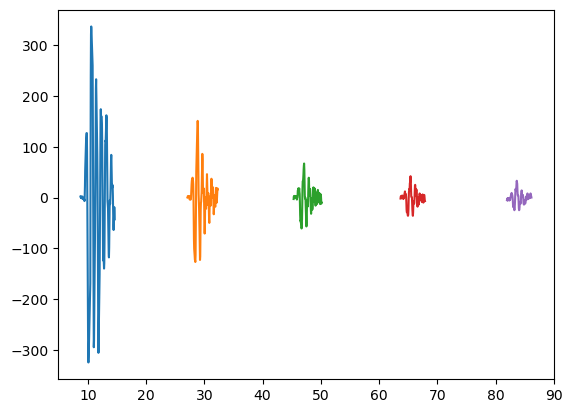

In [4]:
# Load the pulse waveform: it is going to be our time source function
machine_name = "on_bench"
experiment_name = "glued_pzt"
data_type = "data_analysis/pulses_from_glued_pzt"
infile_path_list_pulse  = make_infile_path_list(machine_name=machine_name,experiment_name=experiment_name,data_type=data_type)

pulse_list = []
pulse_metadata_list = []
t_pulse_list = []
time_span = []
for pulse_path in sorted(infile_path_list_pulse): 
    pulse, pulse_metadata = load_waveform_json(pulse_path)
    t_pulse = pulse_metadata['time_ax_waveform']
    time_span.append(np.ptp(t_pulse))
    pulse_list.append(pulse)
    pulse_metadata_list.append(pulse_metadata)
    t_pulse_list.append(t_pulse)
    plt.plot(t_pulse, pulse)

time_span = min(time_span)
# idcut = 17
# pulse = pulse[17:]
# t_pulse = t_pulse[17:]


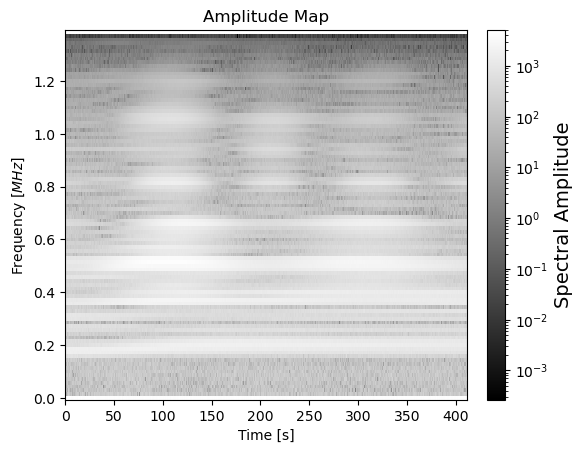

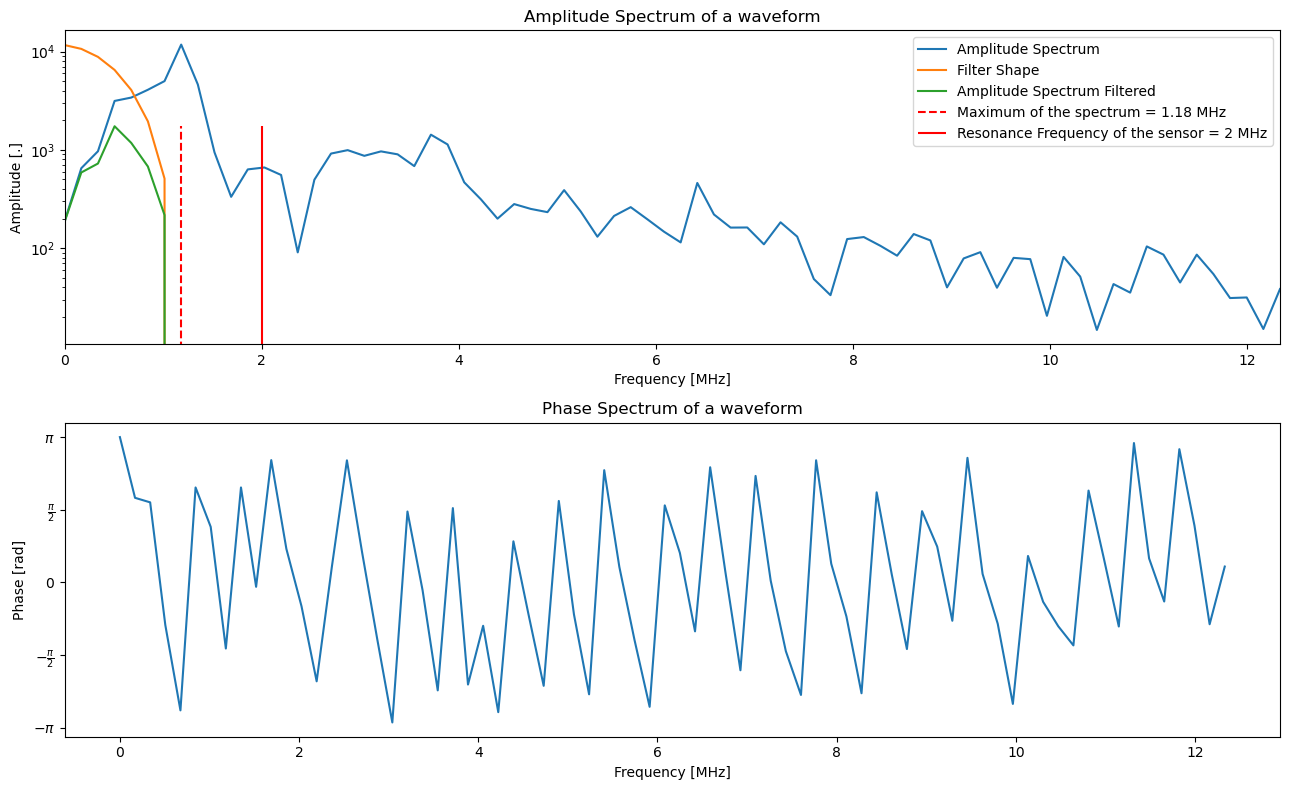

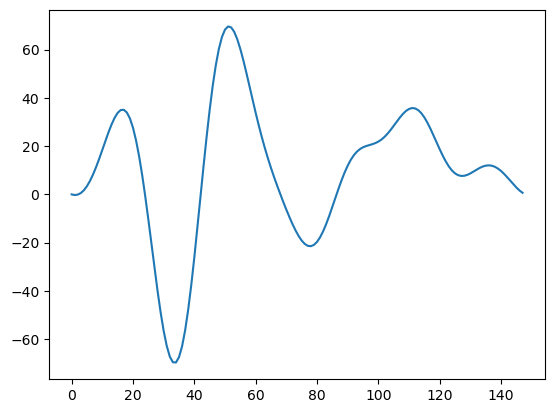

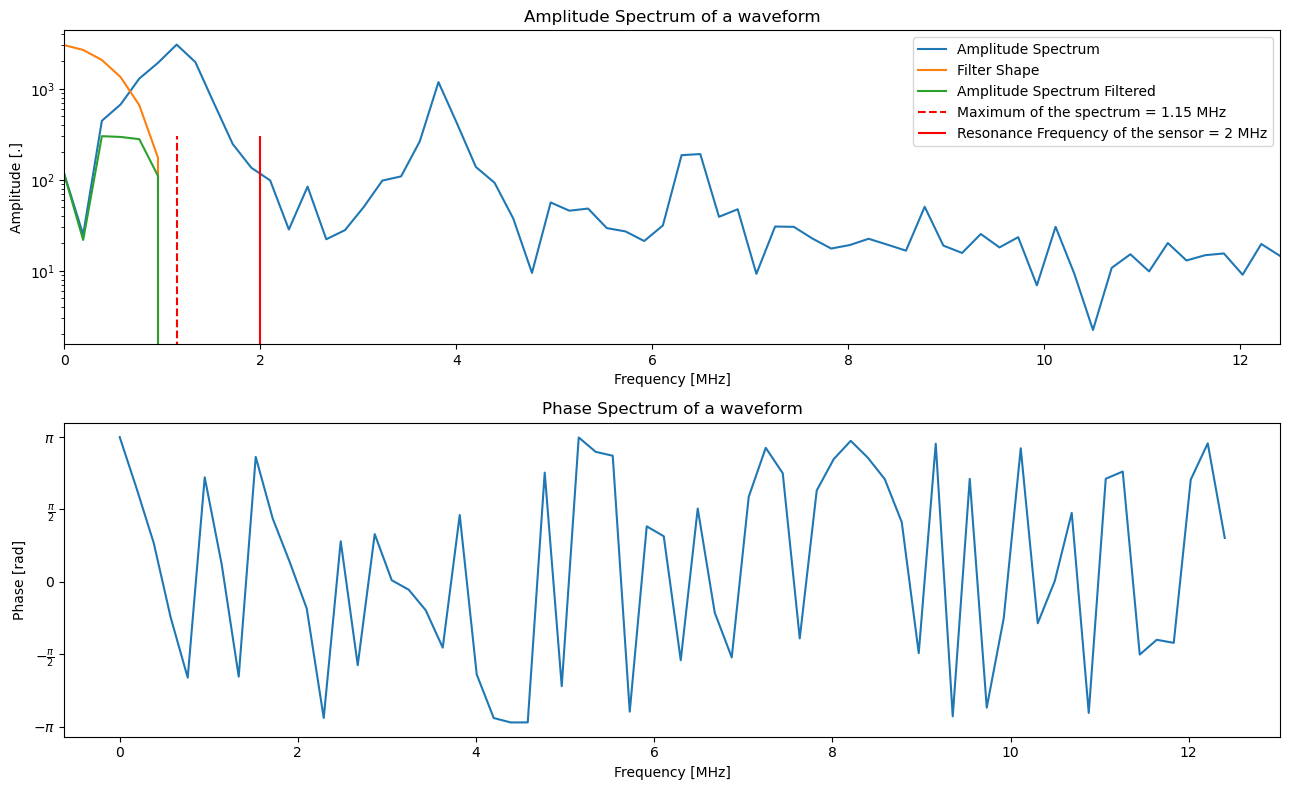

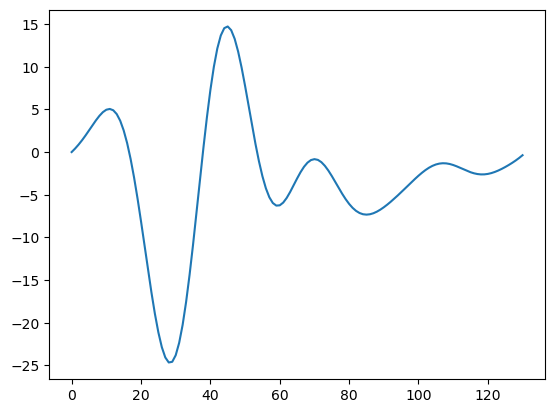

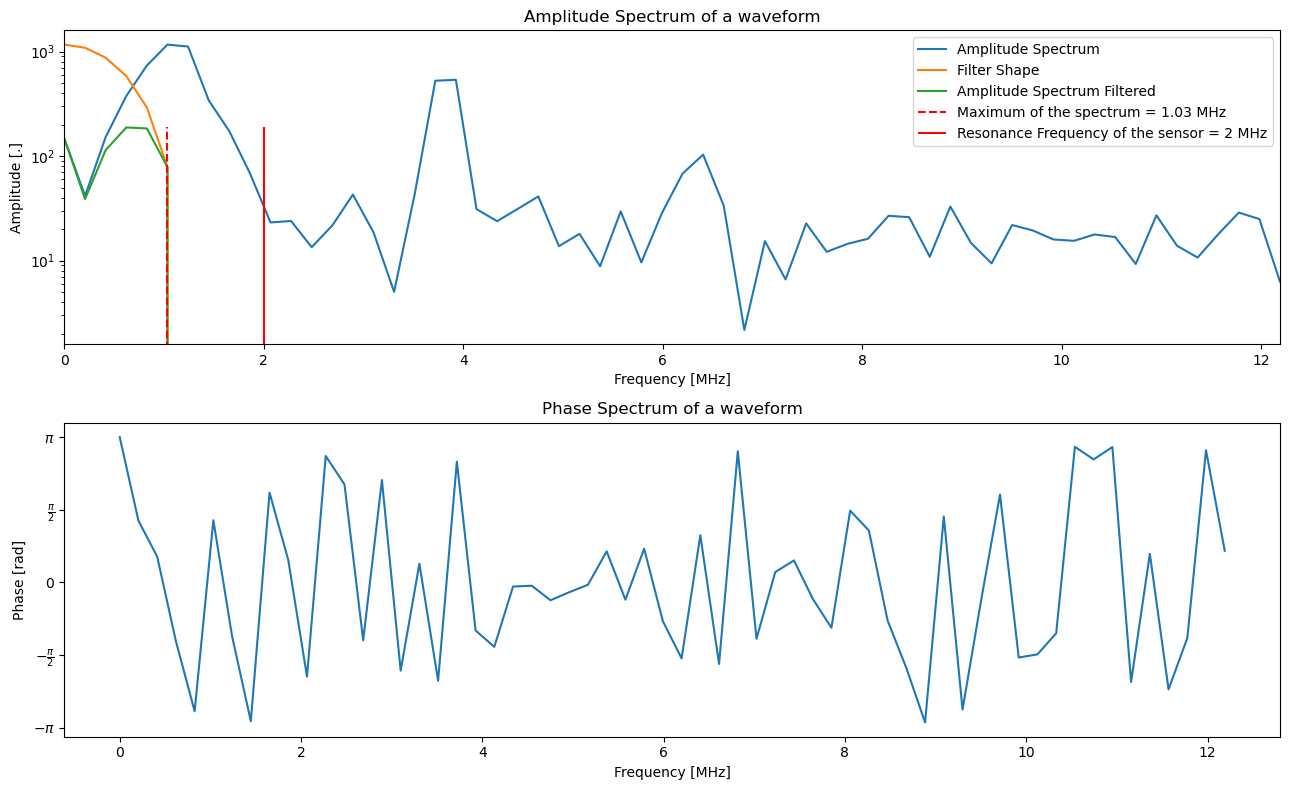

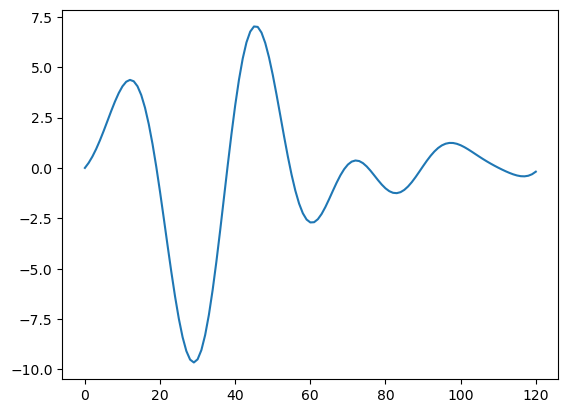

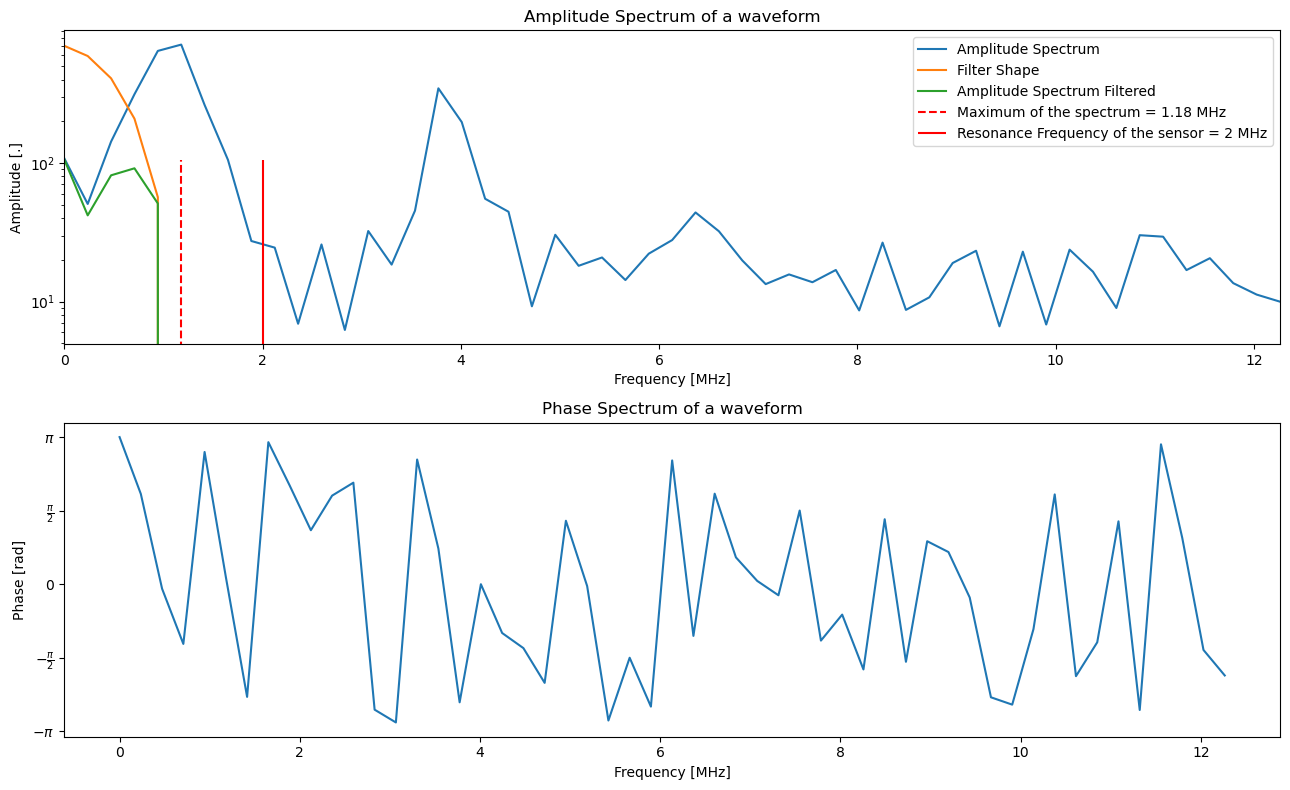

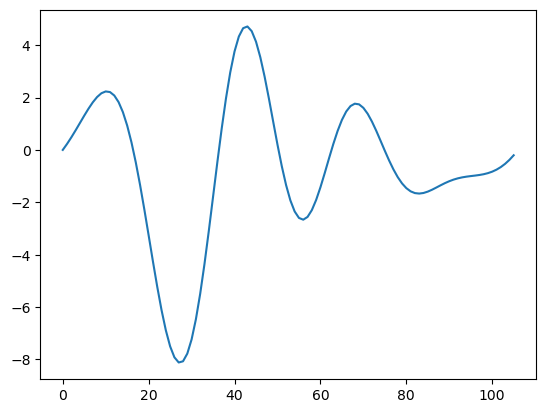

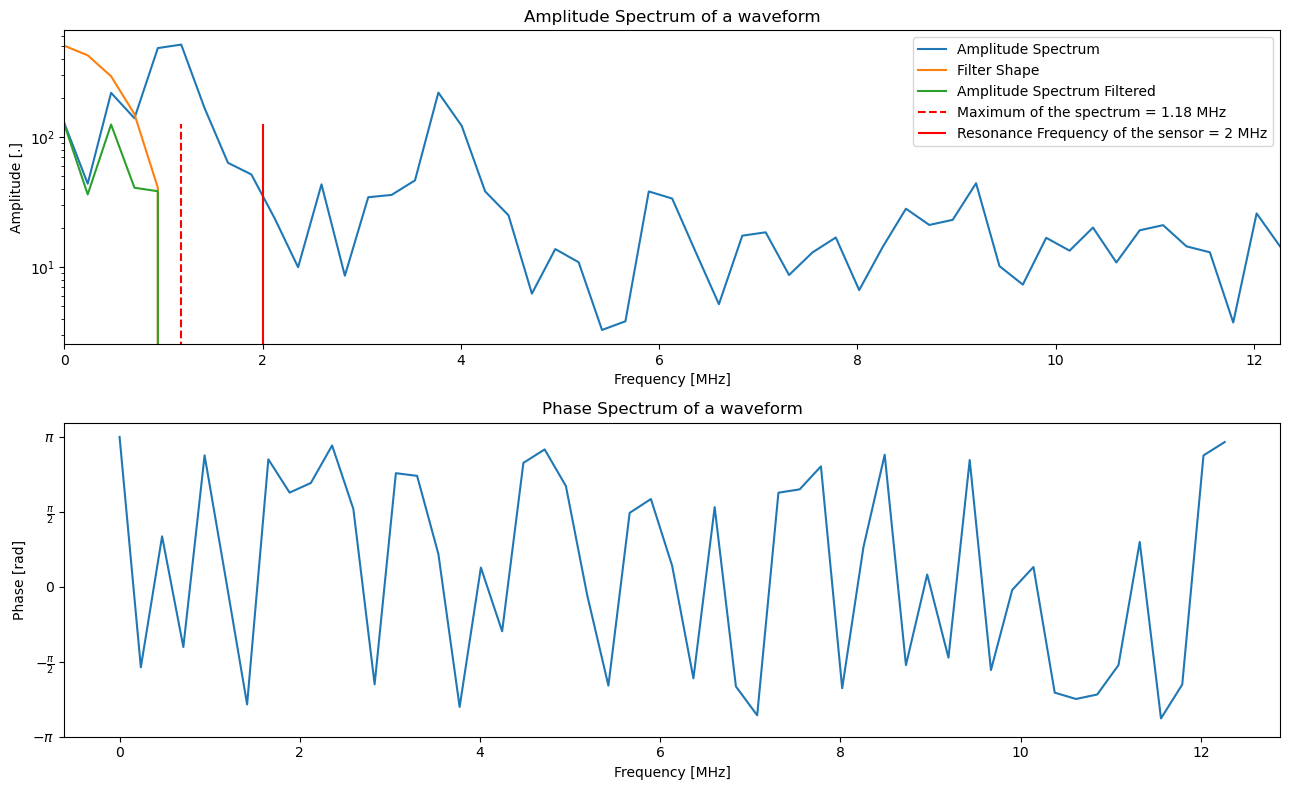

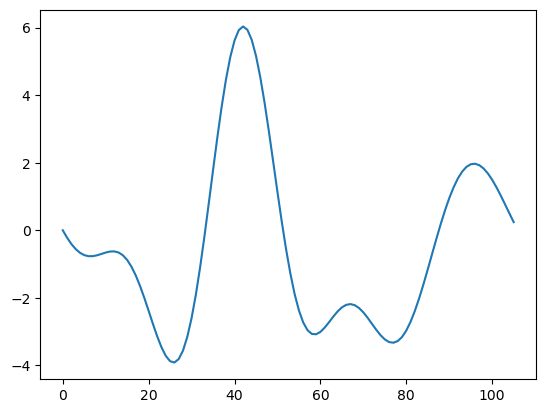

In [5]:
# FREQUENCY LOW PASS:
# reduce computation time 
# # assumtion: there is no point to simulate anything that do not show up in the data_OBS
freq_cut = 1.4                   # [MHz]   maximum frequency of the data we want to reproduce  
data_OBS_filtered, _  = signal2noise_separation_lowpass(data_OBS,metadata,freq_cut=freq_cut)

for i in range(len(pulse_list)):
    pulse_list[i], _  = signal2noise_separation_lowpass(pulse_list[i],pulse_metadata_list[i],freq_cut=freq_cut)
    pulse_list[i] = pulse_list[i] - pulse_list[i][0] 
    plt.plot(pulse_list[i])



#### Pass everything in reasonable units: cm, $\mu s$, MHz

In [6]:

# X ASSES DATA DDS: va salvato anche questo in un buon formato durante l'esperimento!
side_block_1 = 2               # [cm] width of first side block
side_block_2 = 2               # [cm] width of first gouge layer
cetntra_block = 4.8
gouge_1 = 0.4
gouge_2 = 0.4

sample_dimensions = [side_block_1,gouge_1,cetntra_block,gouge_1,side_block_2]  # [cm] total length of the sample

# TRASMISSION AT 0 ANGLE: ONE RECEIVER, ONE TRASMITTER
x_trasmitter = 0.95                              # [cm] position of the trasmitter from the beginning of the sample
x_receiver = sum(sample_dimensions) -0.95        # [cm] position of the receiver from the end of the sample
pzt_width = 0.1                                  # [cm] its important!
pmma_width = 0.1                                 # [cm] plate supporting the pzt


# GUESSED VELOCITY MODEL OF THE SAMPLE
cmax = 3250 * (1e2/1e6)      # [cm/mus]   steel s-velocity
# cair = 330 * (1e2/1e6)       # [cm/mus]   around air p-velocity. Could S-velocity in granular media be less then that?
                             # https://www.sciencedirect.com/science/article/pii/S0041624X15003042
                             # It seems so, but let play easy for now.


cmin = 1000 *  (1e2/1e6)    # [cm/mus]   
cpzt = 2000 * (1e2/1e6)     # [cm/mus] s-velocity in piezo ceramic, beetween 1600 (bad coupling) and 2500 (good one). It matters!!!
                            # according to https://www.intechopen.com/chapters/40134   
cpmma = 0.2*0.1392            # [cm/mus]   plate supporting the pzt

# S- velocity of gouge to probe.
c_step = 100*1e2/1e6
c_gouge_list = np.arange(cmin,0.5*cmax,c_step) # choose of velocity in a reasonable range: from pressure-v in air to s-steel velocity


# DEFINE EVALUATION INTERVAL FOR L2 NORM OF THE RESIDUALS
max_travel_time = 2*(side_block_1-x_trasmitter)/cmax + 2*gouge_1/c_gouge_list[0]+ cetntra_block/cmax
min_travel_time = 2*(side_block_1-x_trasmitter)/cmax + 2*gouge_1/c_gouge_list[-1]+ cetntra_block/cmax
interval = np.where((t_OBS >min_travel_time) & (t_OBS < max_travel_time+time_span))

 

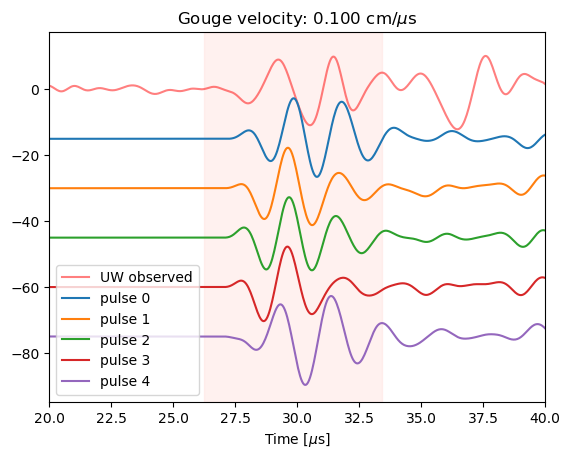

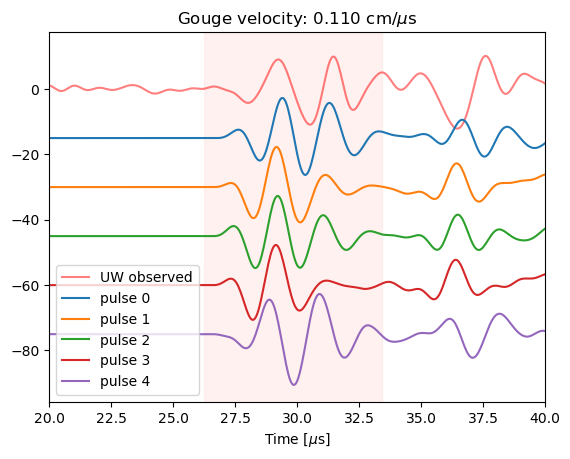

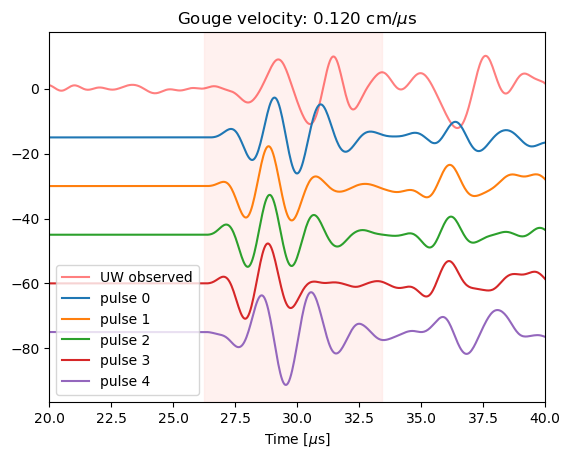

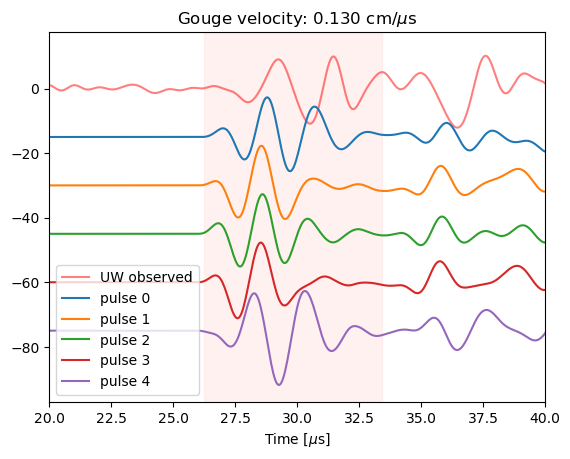

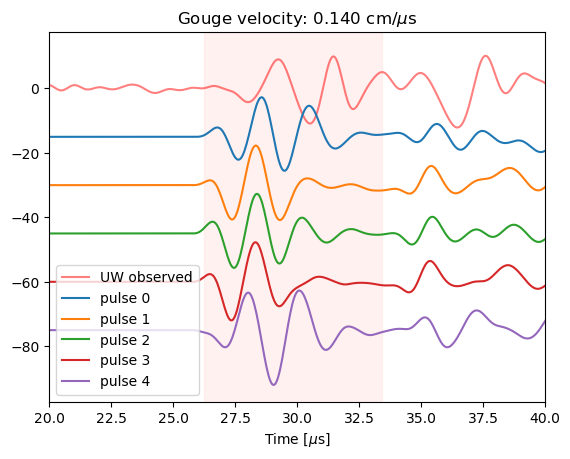

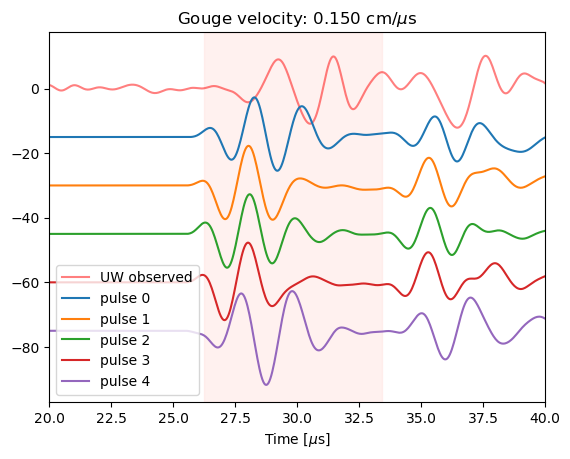

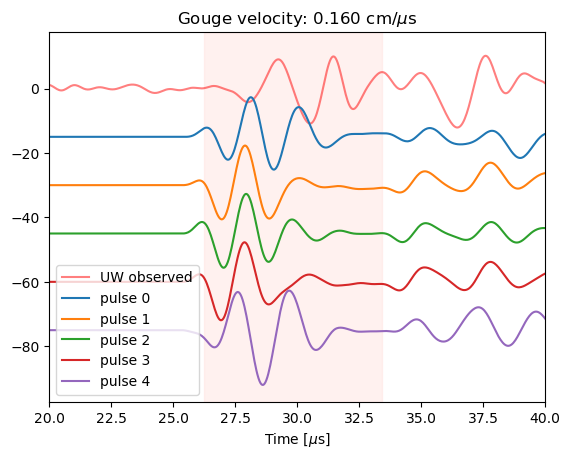

In [7]:
waveform_OBS = data_OBS_filtered[0,:]-np.mean(data_OBS_filtered[0,:])
norm = np.amax(waveform_OBS)

L2norm = np.zeros((len(c_gouge_list), len(pulse_list)))

for idx_gouge, c_gouge in enumerate(c_gouge_list):
    fig = plt.figure()
    plt.plot(t_OBS, waveform_OBS,'r',alpha = 0.5, label= "UW observed")
    plt.axvspan(min_travel_time,max_travel_time+time_span, color="mistyrose", alpha=0.5)

    plt.title(f"Gouge velocity: {c_gouge:.3f} cm/$\mu$s")
    for idx in range(len(pulse_list)):
        pulse = pulse_list[idx]
        t_pulse = t_pulse_list[idx]

   # def DDS_UW_simulation(sample_dimensions,freq_cut, ppt_for_minimum_len, x_trasmitter, x_receiver,pzt_width, pmma_width, cmax,c_gouge,cpzt,cpmma):    
        # DEFINE GRID:
        ppt_for_minimum_len = 10
        x = make_grid_1D(grid_len = sum(sample_dimensions), cmin = c_gouge, fmax=freq_cut, ppt=ppt_for_minimum_len)
        dx = x[1]-x[0]       # [cm/mus] spacing between the point of the x axis     
        nx = len(x)          # number of samples in the simulated x axes. Must be even for pseudo spectral computation. So the if above

        # SOURCE LOCATION COORDINATE INDEX 
        # for now just the index closer to the true trasmission position. Check the error!
        isx = np.argmin(np.abs(x - x_trasmitter))

        # RECEIVER LOCATION COORDINATE INDEX 
        # for now just the index closer to the true RECEIVER position. Check the error!
        irx = np.argmin(np.abs(x - x_receiver))

        # BUILD VELCOTIY MODEL
        c = build_velocity_model(x,sample_dimensions,x_trasmitter,x_receiver, pzt_width, pmma_width, cmax,c_gouge,cpzt,cpmma, plotting= False)

        # DEFINE TIME AX USING CFL CRITERION: https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition
        eps   = 0.5     # stability limit
        dt = eps*dx/cmax; # calculate time step from stability criterion
        t = np.arange(t_OBS[0], t_OBS[-1],dt)   
        nt = len(t)

        # BUILD SOURCE TIME FUNCTION

        # Interpolate time axes of the pulse on the time axes of the simulation
        interpolated_t_pulse = np.arange(t_pulse[0], t_pulse[-1], dt)
        interpolated_pulse = np.interp(interpolated_t_pulse, t_pulse, pulse)
        # interpolated_pulse = np.hanning(len(interpolated_pulse))*interpolated_pulse
        # plt.plot(interpolated_t_pulse,interpolated_pulse)

        src_t = np.zeros(len(t)) 
        src_t[:np.size(interpolated_pulse)] = interpolated_pulse

        # BUILD SOURCE AND RECEIVER SPACIAL FUNCTION
        sigma = pzt_width/4           # is there a smarter way to define it?
                        # width of the gaussian bell representing the pzt spatial profile
                         # with a sigma bigger than this, you are going to see the finite size of the pzt in the waveforms
                         # as a douplet on top of some picks. Investigating it?
        src_x = synthetic_source_spatial_function(x, isx, sigma=sigma, plotting=False)
        # src_x[:isx] = 0
        # well, the trasmitter spatially is identical to the receiver, so
        rec_x = synthetic_source_spatial_function(x, irx, sigma=sigma, plotting=False)
        # src_x[irx+1:] = 0

        # THIS IS THE ACTUAL COMPUTATION OF THE WAVE EQUATION WE RECORD
        sp_field = pseudospectral_1D_forward(nx,dx,nt,dt,src_x,src_t)       
        sp_recorded = np.sum(sp_field*rec_x, axis=-1)    # to account for spacial dimension of the receiver
        waveform_SYNT = np.interp(t_OBS,t,sp_recorded)   # back to the same dt of the observed data

        L2norm[idx_gouge, idx] = LA.norm(waveform_OBS[interval]-waveform_SYNT[interval]*(norm/np.amax(waveform_SYNT)),2)

        plt.plot(t_OBS,waveform_SYNT*(norm/np.amax(waveform_SYNT)) - 15*(idx+1), label=f"pulse {idx}")


    plt.xlim([20,40])
    plt.legend(loc="lower left")
    plt.xlabel("Time [$\mu$s]")
    plt.show()

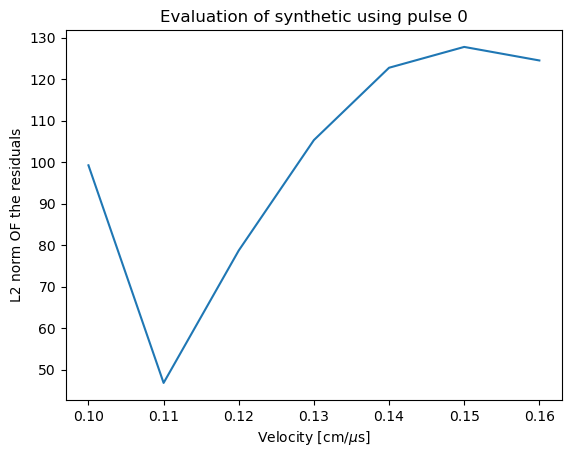

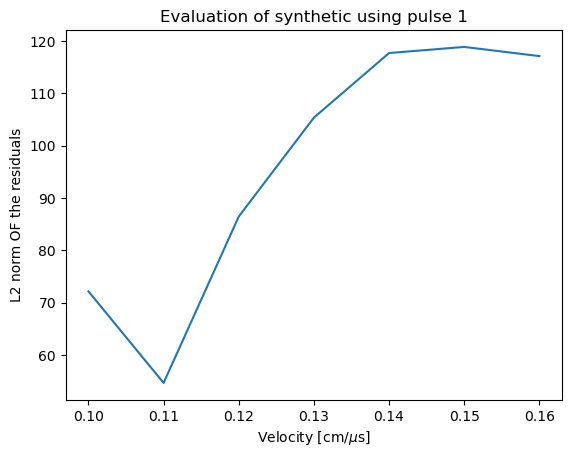

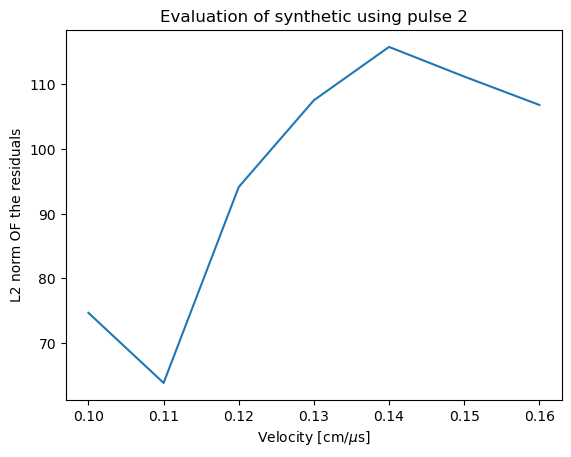

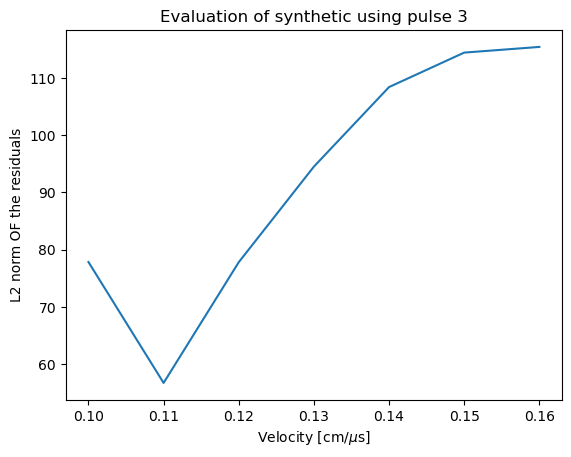

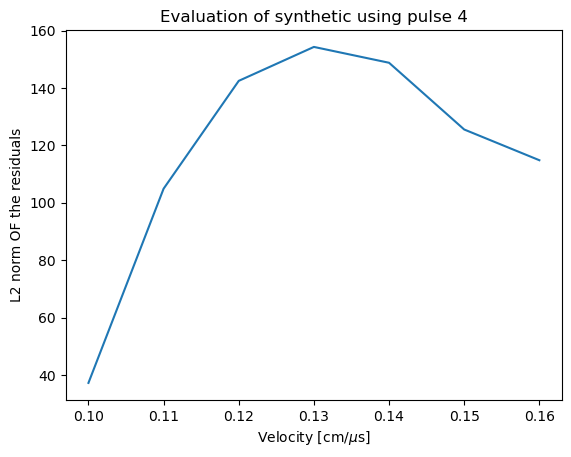

In [10]:
for idx,pulse in enumerate(L2norm.T):
    fig = plt.figure()
    plt.plot(c_gouge_list,pulse)
    plt.xlabel('Velocity [cm/$\mu$s]')
    plt.ylabel('L2 norm OF the residuals')
    plt.title(f'Evaluation of synthetic using pulse {idx}')

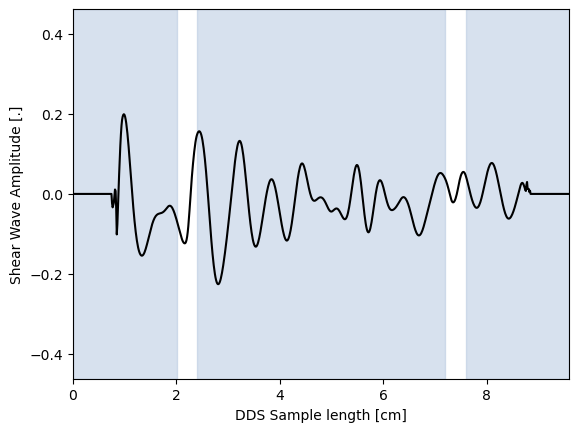

In [9]:
# MAKE A MOVIE FROM THE RECORDED FIELD
movie_sampling = 5             # downsampling of the snapshot to speed up movie

# Initialize figure and axes
fig, ax = plt.subplots()
ylim = 1.3*np.amax(sp_field)   # this is going to be around the higher value of pressure field
ax.set(xlim=[x[0],x[-1]], ylim=[-ylim, ylim], xlabel='DDS Sample length [cm]', ylabel='Shear Wave Amplitude [.]')

# this lines are just to shadow in different colours steel and gouge
idx_gouge_1 =np.where((x>side_block_1) & (x<side_block_1 + gouge_1))[0]
idx_gouge_2 =np.where((x>side_block_1+gouge_1+cetntra_block) & (x<side_block_1 + gouge_1+cetntra_block+gouge_2))[0]
ax.axvspan(x[0],x[idx_gouge_1[0]], color="lightsteelblue", alpha=0.5)
ax.axvspan(x[idx_gouge_1[-1]],x[idx_gouge_2[0]], color="lightsteelblue", alpha=0.5)
ax.axvspan(x[idx_gouge_2[-1]],x[-1], color="lightsteelblue", alpha=0.5)

# Initialize empty line object
line, = ax.plot([], [], 'k', lw=1.5)

# Function to initialize the plot
def init():
    line.set_data([], [])
    return line,


sp_movie = sp_field[::movie_sampling]
# Define the number of frames
num_frames = len(sp_movie)


def movie_uw(frame):
    # Plot x against sp__movie
    line.set_xdata(x)
    line.set_ydata(sp_movie[frame])
    return line,

# Create animation
ani = animation.FuncAnimation(fig, movie_uw, frames=num_frames, blit=True, interval=20)

# Save the animation as an MP4 file
ani.save('simulation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])






